In [6]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.0.0


Keras provides a handy API to download mnist dataset. Also we are spliting our dataset into test and train set.

In [7]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Normalize the input image so that each pixel value is between 0 to 1.


In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0
print('Pixels are normalized')

Pixels are normalized


Show the first 25 images in the training dataset.

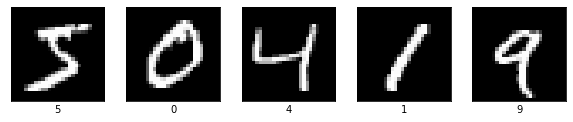

In [10]:
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

Train a TensorFlow model to classify digit images
i. Our model takes a 28px x 28px grayscale image as an input, and ii. outputs a float array of length 10 representing the probability      of the image being a digit from 0 to 9.

Here we use a simple convolutional neural network, which is a common technique in computer vision.

2D convolution layer
1.filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
2.kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
activation: Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).

In [45]:

model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=24, kernel_size=(3, 3),activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_images, train_labels, epochs=15)

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 25s 425us/sample - loss: 0.2645 - accuracy: 0.9251
Epoch 2/15
60000/60000 [==============================] - 25s 419us/sample - loss: 0.0982 - accuracy: 0.9719
Epoch 3/15
60000/60000 [==============================] - 25s 416us/sample - loss: 0.0757 - accuracy: 0.9780
Epoch 4/15
60000/60000 [==============================] - 25s 414us/sample - loss: 0.0650 - accuracy: 0.9817
Epoch 5/15
60000/60000 [==============================] - 25s 413us/sample - loss: 0.0589 - accuracy: 0.9829
Epoch 6/15
60000/60000 [==============================] - 25s 414us/sample - loss: 0.0556 - accuracy: 0.9845
Epoch 7/15
60000/60000 [==============================] - 25s 418us/sample - loss: 0.0528 - accuracy: 0.9850
Epoch 8/15
60000/60000 [==============================] - 25s 413us/sample - loss: 0.0507 - accuracy: 0.9858
Epoch 9/15
60000/60000 [==============================] - 25s 412us/sample - loss: 0.0488 - accuracy: 0.9

In [46]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

A helper function that returns 'red'/'black' depending on if its two input
parameter matches or not.

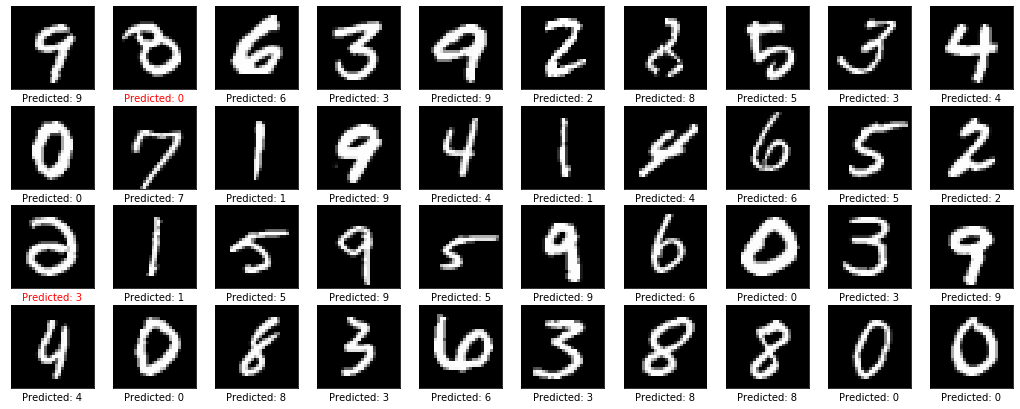

In [51]:

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'


predictions = model.predict(test_images)

prediction_digits = np.argmax(predictions, axis=1)

plt.figure(figsize=(18, 18))
for i in range(40):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

Convert Keras model to TF Lite format.
Show model size in KBs.

In [53]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 161KBs.


Re-convert the model to TF Lite using quantization. Show model size in KBs.

In [54]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 42KBs,
which is about 26% of the float model size.


A helper function to evaluate the TF Lite model using "test" dataset.

In [0]:

def evaluate_tflite_model(tflite_model):
  
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  prediction_digits = []
  for test_image in test_images:

    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    interpreter.invoke()

    
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)


  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy



Evaluate the TF Lite float model. Its accurary is identical to the original TF (Keras) model because they are essentially the same model
stored in different format.

In [56]:

float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)



Float model accuracy = 0.9827


Evalualte the TF Lite quantized model.

In [57]:

quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))

Quantized model accuracy = 0.9831
Accuracy drop = -0.0004


Save the quantized model to file to the Downloads directory. Download the digit classification model

In [59]:
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()


from google.colab import files
files.download('mnist.tflite')

print('mnist.tflite has been downloaded')

mnist.tflite has been downloaded
